# 01 EDA
Load data, check leakage, quick plots.

In [32]:
# --- imports
from pathlib import Path
import re, unicodedata

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# --- canonicalize column names (one source of truth)
def canon(name: str) -> str:
    s = unicodedata.normalize("NFKC", str(name))
    s = s.replace("\u200b", "").replace("\xa0", "")  # zero-width/NBSP
    s = s.strip().lower()
    # normalize micro symbol(s) to plain 'u'
    s = s.translate(str.maketrans({"µ": "u", "μ": "u"}))
    # standardize unit token variants
    s = s.replace("umol m-2 s-1", "umol_m2_s1")
    s = s.replace("umol/m2/s",  "umol_m2_s1")
    s = s.replace("umol m^-2 s^-1", "umol_m2_s1")
    # collapse non-alnum to underscores
    s = re.sub(r"[^a-z0-9]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s

# project paths (assumes you're running from notebooks/)
ROOT = Path.cwd().parents[0]          # repo root
DATA = ROOT / "data" / "processed"

# file names
IN_CSV  = DATA / "microalgae_dataset.csv"         # change if your source differs
OUT_CSV = DATA / "microalgae_dataset_clean.csv"   # canonicalized output

TARGET = "co2_fixation_g_l_day"  # <- our canonical target name


In [34]:
# read; your files are semicolon delimited and saved with BOM (utf-8-sig)
df = pd.read_csv(IN_CSV, sep=";", encoding="utf-8-sig")

# normalize headers (fixes µ → u, spaces/punct → _, etc.)
df.columns = [canon(c) for c in df.columns]

print("Shape:", df.shape)
df.head()

Shape: (300, 12)


,sample_id,day_index,air_temp_c,light_intensity_umol_m2_s1,ph_before_injection,ph_after_injection,do_mg_l,salinity_psu,optical_density,dry_weight_g_l,growth_rate,co2_fixation_g_l_day
0,c1m1,1.0,28.2,108.01,8.11,8.02,3.86,33.0,0.1500,0.000000e+00,0.000000,0.000000
1,c1m1,2.0,28.0,104.65,8.14,8.07,4.00,31.0,0.1660,7.000000e-07,0.000001,0.000001
2,c1m1,3.0,26.5,106.83,8.21,8.01,4.30,35.0,0.1680,2.180000e-05,0.000021,0.000039
3,c1m1,4.0,25.7,100.97,8.25,8.08,4.26,29.0,0.1950,3.134000e-04,0.000292,0.000534
4,c1m1,5.0,25.4,104.97,8.25,8.07,4.04,30.0,0.1859,2.510100e-03,0.002197,0.004020


In [35]:
# info & numeric summary
display(df.info())
display(df.describe(numeric_only=True).T.round(4))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sample_id                   296 non-null    object 
 1   day_index                   296 non-null    float64
 2   air_temp_c                  296 non-null    float64
 3   light_intensity_umol_m2_s1  296 non-null    float64
 4   ph_before_injection         296 non-null    float64
 5   ph_after_injection          296 non-null    float64
 6   do_mg_l                     296 non-null    float64
 7   salinity_psu                296 non-null    float64
 8   optical_density             296 non-null    float64
 9   dry_weight_g_l              296 non-null    float64
 10  growth_rate                 296 non-null    float64
 11  co2_fixation_g_l_day        296 non-null    float64
dtypes: float64(11), object(1)
memory usage: 28.3+ KB


None

TypeError: NDFrame.describe() got an unexpected keyword argument 'numeric_only'

In [36]:
# missing values
missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0])

# duplicates (all cols)
dup_rows = df.duplicated().sum()
print("Duplicate rows:", dup_rows)

# constant columns (no variance)
num_cols = df.select_dtypes(include="number").columns
constant = [c for c in num_cols if df[c].nunique(dropna=False) <= 1]
print("Constant numeric columns:", constant)

sample_id                     4
day_index                     4
air_temp_c                    4
light_intensity_umol_m2_s1    4
ph_before_injection           4
ph_after_injection            4
do_mg_l                       4
salinity_psu                  4
optical_density               4
dry_weight_g_l                4
growth_rate                   4
co2_fixation_g_l_day          4
dtype: int64

Duplicate rows: 3
Constant numeric columns: []


In [19]:
df.info()
df.describe(include="all").T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ﻿sample_id                  296 non-null    object 
 1   day_index                   296 non-null    float64
 2   air_temp_c                  296 non-null    float64
 3   light_intensity_µmol_m2_s1  296 non-null    float64
 4   ph_before_injection         296 non-null    float64
 5   ph_after_injection          296 non-null    float64
 6   do_mg_l                     296 non-null    float64
 7   salinity_psu                296 non-null    float64
 8   optical_density             296 non-null    float64
 9   dry_weight_g_l              296 non-null    float64
 10  growth_rate                 296 non-null    float64
 11  co2_fixation_g_l_day        296 non-null    float64
dtypes: float64(11), object(1)
memory usage: 28.3+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
﻿sample_id,296,9,c2m2,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_index,296.0,NaN,NaN,NaN,16.996622,9.596432,1.0,9.0,17.0,25.0,36.0
air_temp_c,296.0,NaN,NaN,NaN,25.228716,1.30568,22.2,24.5,25.3,26.0,29.2
light_intensity_µmol_m2_s1,296.0,NaN,NaN,NaN,104.534932,2.568892,100.05,102.3975,104.61,106.7375,108.84
ph_before_injection,296.0,NaN,NaN,NaN,8.447128,0.500241,7.72,8.12,8.26,8.59,10.02
ph_after_injection,296.0,NaN,NaN,NaN,6.820676,0.795051,5.54,6.185,6.61,7.73,8.59
do_mg_l,296.0,NaN,NaN,NaN,3.947601,0.396656,2.93,3.6675,3.92,4.1925,5.17
salinity_psu,296.0,NaN,NaN,NaN,34.858108,1.369821,29.0,34.0,35.0,35.5,40.0
optical_density,296.0,NaN,NaN,NaN,0.845885,0.673254,0.0685,0.1995,0.704,1.3835,2.4
dry_weight_g_l,296.0,NaN,NaN,NaN,2.022499,1.865336,0.0,0.227295,1.642903,3.500854,6.145367


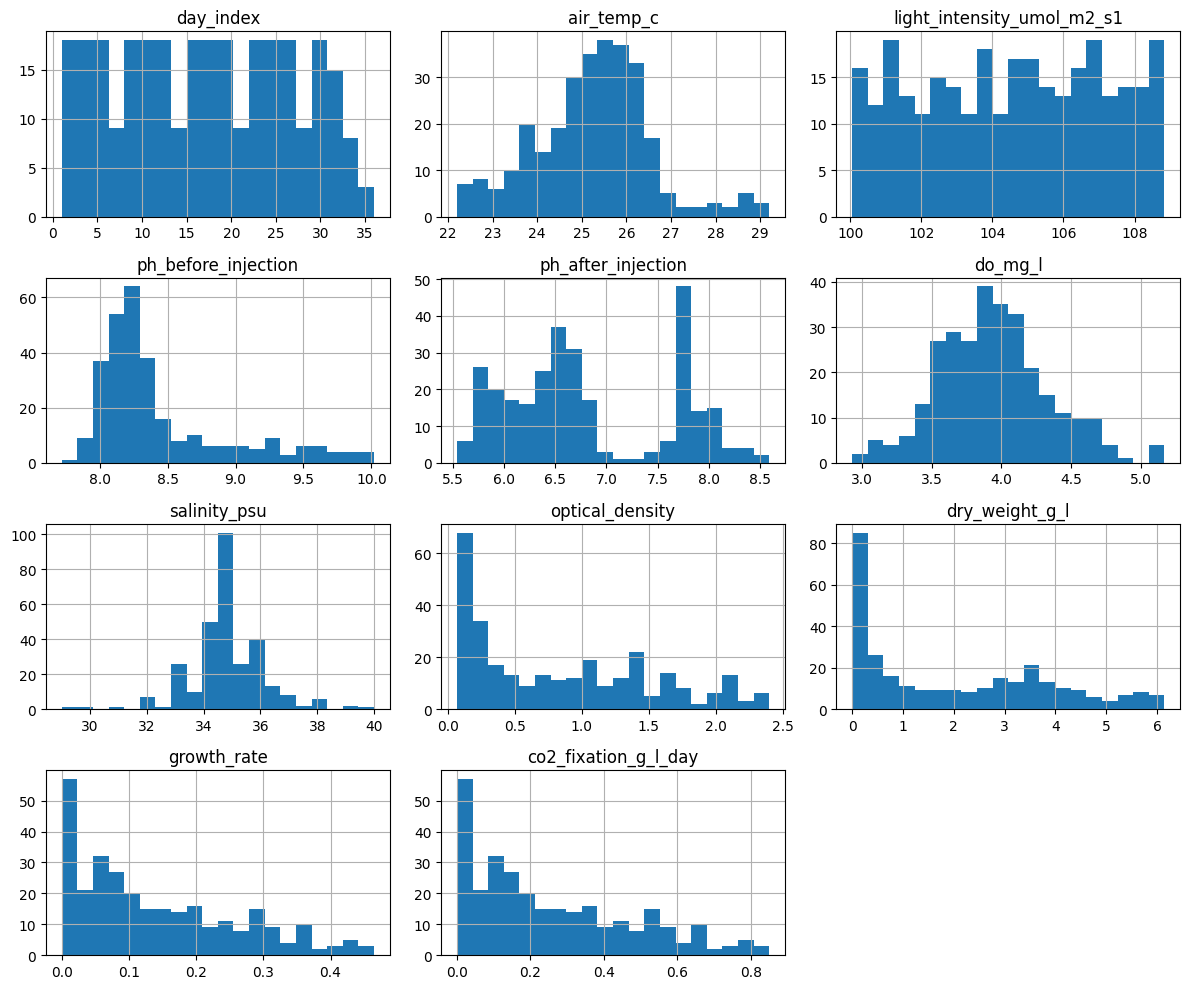

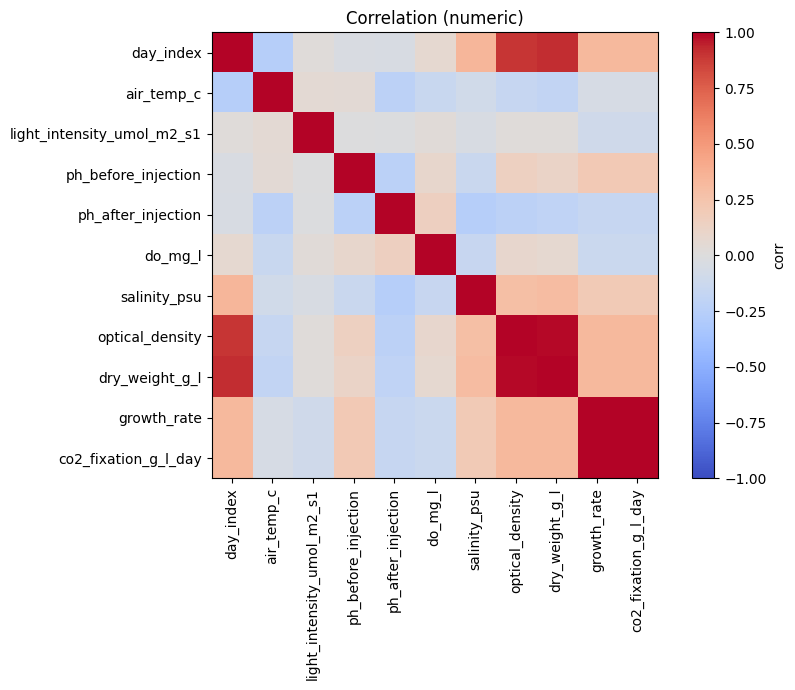

In [37]:
# histograms for numeric columns
_ = df[num_cols].hist(figsize=(12, 10), bins=20)
plt.tight_layout(); plt.show()

# correlation matrix (numeric only)
corr = df[num_cols].corr()
plt.figure(figsize=(9, 7))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="corr")
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation (numeric)")
plt.tight_layout(); plt.show()


In [38]:
# ensure target exists (try to help if not)
if TARGET not in df.columns:
    from difflib import get_close_matches
    close = get_close_matches(TARGET, df.columns, n=5, cutoff=0.5)
    raise KeyError(f"Target '{TARGET}' not found. Close matches: {close}")

# leakage: any feature EXACTLY equals target?
dup = (df[num_cols].eq(df[TARGET], axis=0)).all()
dup_feats = dup[dup].index.tolist()
print("Features identical to target:", dup_feats)

# correlation with target
corr_to_target = df[num_cols].corrwith(df[TARGET]).sort_values(key=np.abs, ascending=False)
print("Top correlations with target:")
display(corr_to_target.head(10))


Features identical to target: []
Top correlations with target:


co2_fixation_g_l_day          1.000000
growth_rate                   1.000000
dry_weight_g_l                0.325366
optical_density               0.325334
day_index                     0.322785
ph_before_injection           0.206634
salinity_psu                  0.202701
ph_after_injection           -0.156492
do_mg_l                      -0.131496
light_intensity_umol_m2_s1   -0.095523
dtype: float64

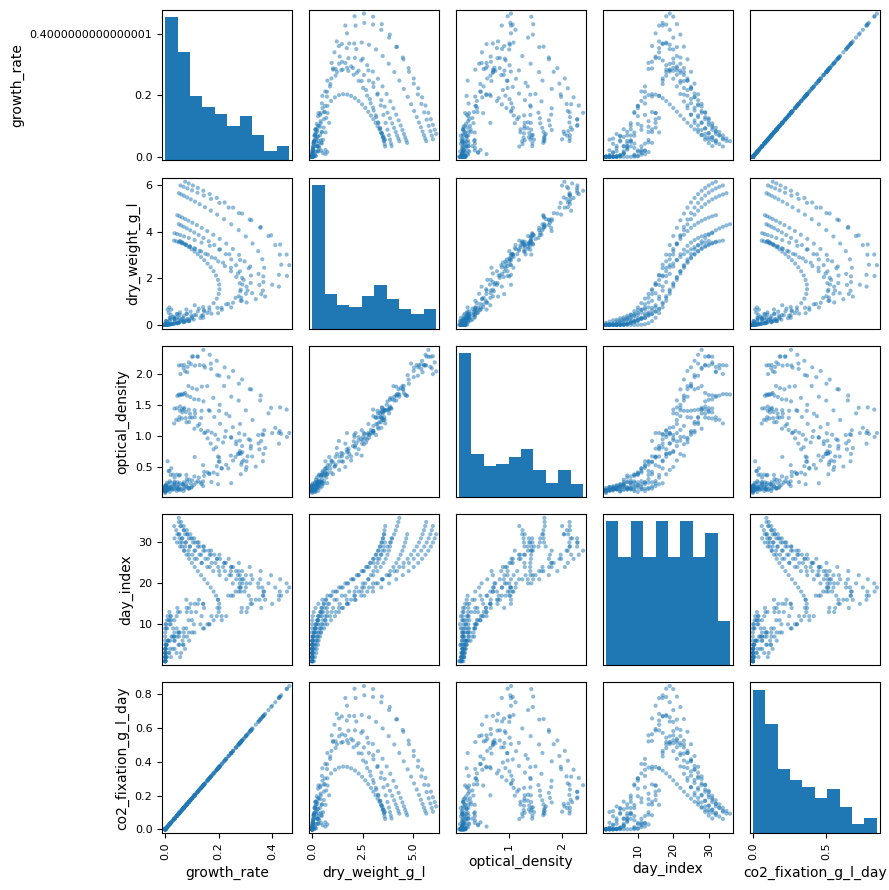

In [39]:
# choose top 4 numeric features (by absolute corr), plus target
top_feats = [c for c in corr_to_target.index if c != TARGET][:4]
cols_for_scatter = top_feats + [TARGET]

scatter_matrix(df[cols_for_scatter], figsize=(9, 9), diagonal='hist')
plt.tight_layout(); plt.show()


In [40]:
# simple z-score flag (|z| > 3) for numeric cols
z = (df[num_cols] - df[num_cols].mean()) / df[num_cols].std(ddof=0)
outlier_counts = (z.abs() > 3).sum().sort_values(ascending=False)
print("Potential outliers per column (|z|>3):")
display(outlier_counts[outlier_counts > 0])


Potential outliers per column (|z|>3):


salinity_psu           5
ph_before_injection    3
air_temp_c             1
do_mg_l                1
dtype: int64

In [41]:
# keep same delimiter style
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(OUT_CSV, sep=";", index=False, encoding="utf-8-sig")
OUT_CSV


WindowsPath('D:/6 Project/ZeroAlgae/Research/carbon-fixation-ml-starter/data/processed/microalgae_dataset_clean.csv')